In this notebook, we run all of the model evaluation, including
- General performance (overall and by subgroup)
- Performance over time
- Stability analysis
- Sensitivity analysis

In [1]:
import numpy as np
import os
import pandas as pd
import pyodbc
import time
import scipy.stats as stats
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from datetime import datetime
import sys
import gc
from scipy.sparse import csr_matrix
import pickle
import joblib
from itertools import product
import matplotlib
import plotly.graph_objects as go
import plotly.offline as po


from xgboost import XGBClassifier, plot_importance, DMatrix
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression

In [2]:
path = '../'

# Define Functions

In [4]:
def get_ci(y_test, y_pred, threshold=0.95):
    """
    gives us 95% CI for auroc, auprc
    """
    rng = np.random.RandomState(seed=44)
    idx = np.arange(y_test.shape[0])

    test_auroc = []
    test_auprc = []
    for i in range(300):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        if len(set(y_test.iloc[pred_idx])) > 1:
            test_auroc.append(roc_auc_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            test_auprc.append(precision_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            
    auroc_interval = (np.percentile(test_auroc, 2.5), np.percentile(test_auroc, 97.5))
    auprc_interval = (np.percentile(test_auprc, 2.5), np.percentile(test_auprc, 97.5))
    
    return auroc_interval, auprc_interval

In [5]:
def results_per_iter(test_value_subset, iterations_name):
    iterations = test_value_subset[iterations_name].unique()
    iterations.sort()
    auroc = []
    auroc_ci = []
    auprc = []
    auprc_ci = []

    num_patients = []
    frac_pos_samples = []
    num_visits = []
    num_visits_ci = []
    for i in iterations:
        df_subset = test_value_subset.loc[test_value_subset[iterations_name]==i]
        if len(df_subset['sz_flag'].unique()) > 1:
            auroc_val = roc_auc_score(df_subset['sz_flag'], df_subset['y_pred'])
            auroc.append(auroc_val)
            
            auprc_val = precision_score(df_subset['sz_flag'], df_subset['y_pred'])
            auprc.append(auprc_val)
            
            confidence_intervals = get_ci(df_subset['sz_flag'], df_subset['y_pred'])
            auroc_ci.append(confidence_intervals[0])
            auprc_ci.append(confidence_intervals[1])
        else:
            print('iteration',i, 'has only one class')
            auroc.append(np.nan)
            auroc_ci.append((np.nan, np.nan))
            auprc.append(np.nan)
            auprc_ci.append((np.nan, np.nan))
            

        num_patients.append(len(df_subset))
        frac_pos_samples.append(sum(df_subset['sz_flag'])/len(df_subset))
        num_visits.append(np.mean(df_subset['iteration']*10))
        num_visits_ci.append(stats.sem(df_subset['iteration']*10) * stats.t.ppf((1 + 0.95) / 2., len(df_subset)-1))
        
    return auroc, auroc_ci, auprc, auprc_ci, num_patients, frac_pos_samples, num_visits, num_visits_ci

In [6]:
def get_ci_all_table(y_test, y_pred, threshold=0.95):
    """
    gives us 95% CI for auroc, auprc
    """
    rng = np.random.RandomState(seed=44)
    idx = np.arange(y_test.shape[0])

    test_auroc = []
    test_acc = []
    test_sensitivity = []
    test_specificity = []
    for i in tqdm(range(300)):
        pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
        if len(set(y_test.iloc[pred_idx])) > 1:
            test_auroc.append(roc_auc_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            test_acc.append(accuracy_score(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]))
            tn, fp, fn, tp = confusion_matrix(y_test.iloc[pred_idx], y_pred.iloc[pred_idx]).ravel()
            test_sensitivity.append(tp/(tp+fn))
            test_specificity.append(tn/(tn+fp))

            
    auroc_interval = (np.percentile(test_auroc, 2.5), np.percentile(test_auroc, 97.5))
    acc_interval = (np.percentile(test_acc, 2.5), np.percentile(test_acc, 97.5))
    sensitivity_interval = (np.percentile(test_sensitivity, 2.5), np.percentile(test_sensitivity, 97.5))
    specificity_interval = (np.percentile(test_specificity, 2.5), np.percentile(test_specificity, 97.5))
    
    return auroc_interval, acc_interval, sensitivity_interval, specificity_interval

def create_table2_row(sample_test):
    auroc_interval, acc_interval, sensitivity_interval, specificity_interval = get_ci_all_table(sample_test['sz_flag'], sample_test['y_pred'])
    auroc = roc_auc_score(sample_test['sz_flag'], sample_test['y_pred'])
    acc = accuracy_score(sample_test['sz_flag'], sample_test['y_pred'])
    tn, fp, fn, tp = confusion_matrix(sample_test['sz_flag'], sample_test['y_pred']).ravel()
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    
    return [auroc, auroc_interval, acc, acc_interval, sensitivity, sensitivity_interval, 
            specificity, specificity_interval]

## Set up test dataset + predictions for the XGBoost model

### Read in data



In [7]:
list_files = []
list_filenames = os.listdir('stored_data/visit_iters_6')
for filename_ind in tqdm(range(len(list_filenames))):
    filename = list_filenames[filename_ind]
    list_files.append(pd.read_csv('stored_data/visit_iters_6/'+filename))

100%|██████████████████████████████████████████████████| 590/590 [04:58<00:00,  1.98it/s]


In [8]:
df_all_iters = pd.concat(list_files)
df_all_iters.fillna(0, inplace=True)

In [9]:
num_days_prediction = 90
df_pop = pd.read_csv(path+'population.csv')
df_pop.rename({'psychosis_dx_date':'psychosis_diagnosis_date'}, axis=1, inplace=True)
df_pop['psychosis_diagnosis_date'] = pd.to_datetime(df_pop['psychosis_diagnosis_date'], format="%Y-%m-%d")
df_pop['cohort_start_date'] = pd.to_datetime(df_pop['cohort_start_date'])
df_pop = df_pop.loc[(df_pop['cohort_start_date']-df_pop['psychosis_diagnosis_date']).dt.days >= num_days_prediction]

df_pop = df_pop.loc[df_pop['person_id'].isin(df_all_iters['person_id'])]

In [10]:
labels = df_all_iters[['person_id', 'iteration']].merge(df_pop[['person_id','sz_flag']], how='left', left_on = 'person_id', right_on='person_id')
labels.set_index('person_id', inplace=True)

df_all_iters.set_index('person_id', inplace=True)
df_all_iters.drop(['iteration'], inplace=True, axis=1)

In [11]:
pid_train, pid_test, y_train, y_test = train_test_split(df_pop['person_id'], df_pop['sz_flag'], stratify=df_pop['sz_flag'], test_size=0.3, random_state = 4)

X_train = df_all_iters.loc[pid_train.values]
X_test = df_all_iters.loc[pid_test.values]

y_train = labels.loc[pid_train.values, 'sz_flag']
y_test = labels.loc[pid_test.values, 'sz_flag']

In [12]:
save_cols = df_all_iters.columns

In [13]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
del X_train
del df_all_iters
gc.collect()

0

### Load model and make predictions

In [15]:
df_iter_pop = pd.read_csv('stored_data/iterated_population_6_visits.csv')
iterated_testing_df = df_iter_pop.loc[df_iter_pop['person_id'].isin(pid_test.values)]

with open('models/xgb_every_6_visits.pkl', 'rb') as f:
    testing_clf = pickle.load(f)

In [16]:
y_pred_proba = testing_clf.predict_proba(X_test)
test_labels = labels.loc[pid_test.values]

test_labels['prob_0'] = y_pred_proba[:,0]
test_labels['prob_1'] = y_pred_proba[:,1]
test_labels['y_pred'] = np.round(test_labels['prob_1'])
test_labels.reset_index(inplace=True)
test_labels = test_labels.merge(iterated_testing_df[['person_id', 'iteration', 'years_obs', 'psychosis_diagnosis_date', 'cutoff_date', 'cohort_start_date','censor_date', 'first_visit']], how = 'left', left_on = ['person_id', 'iteration'], right_on = ['person_id', 'iteration'])

In [17]:
test_labels['psychosis_diagnosis_date'] = pd.to_datetime(test_labels['psychosis_diagnosis_date'])
test_labels['cutoff_date'] = pd.to_datetime(test_labels['cutoff_date'])
test_labels['censor_date'] = pd.to_datetime(test_labels['censor_date'])

# get time from psychosis dx to cutoff
test_labels['time_to_cutoff'] = (test_labels['cutoff_date']-test_labels['psychosis_diagnosis_date']).dt.days/365
print(test_labels['time_to_cutoff'].max())

# get time from psychosis dx to censor
test_labels['time_to_censor'] = (test_labels['censor_date']-test_labels['psychosis_diagnosis_date']).dt.days/365

9.756164383561643


In [18]:
test_labels = test_labels.merge(df_pop[['person_id', 'race_concept_id', 'gender_concept_id']], how='left',
                 left_on='person_id', right_on='person_id')

## Table 2: overall performance, incl. by demographics

In [ ]:
table2 = pd.DataFrame(columns = ['AUROC', 'AUROC CI', 'Accuracy', 'Accuracy CI',
                                   'Sensitivity', 'Sensitivity CI', 'Specificity', 'Specificity CI'])

table2.loc['All'] = create_table2_row(test_labels)

black_patients = test_labels.loc[test_labels['race_concept_id']==8516]
table2.loc['Black'] = create_table2_row(black_patients)

white_patients = test_labels.loc[test_labels['race_concept_id']==8527]
table2.loc['White'] = create_table2_row(white_patients)

female_patients = test_labels.loc[test_labels['gender_concept_id']==8532]
table2.loc['Women'] = create_table2_row(female_patients)

male_patients = test_labels.loc[test_labels['gender_concept_id']==8507]
table2.loc['Men'] = create_table2_row(male_patients)
table2

## Figure 1: Performance over time, incl. by demogrpahics

In [19]:
# because we have a max of 9.75 years, we will look up to 10 years
time_checks = np.arange(0,10.5,0.5)
test_labels_with_index = test_labels.set_index(['person_id', 'iteration'])

list_timed_subgroups = []
for ind in time_checks:

    # get the max iteration where the time between psychosis and cutoff is still under our time
    most_recent_visit = (test_labels.loc[test_labels['time_to_cutoff']<= ind].groupby('person_id').max()['iteration']).reset_index().values
    timed_subgroup = test_labels_with_index.loc[list(map(tuple, most_recent_visit))]

    # remove anyone for whom the time between psychosis and censor date is less than the 
    # amount of time out we are looking (i.e. they have reached their index date)
    timed_subgroup = timed_subgroup.loc[timed_subgroup['time_to_censor']>=ind]
    
    timed_subgroup['time_forward_iteration'] = ind
    list_timed_subgroups.append(timed_subgroup)
forward_iter_test_labels = pd.concat(list_timed_subgroups)


In [20]:
forward_iter_test_labels.reset_index(inplace=True)

In [21]:
## Forwards iterations, by time
iterations = forward_iter_test_labels['time_forward_iteration'].unique()
iterations.sort()
auroc, auroc_ci, auprc, auprc_ci, num_patients, frac_pos_samples, num_visits, num_visits_ci = results_per_iter(forward_iter_test_labels, 'time_forward_iteration')

In [22]:
black_patients = forward_iter_test_labels.loc[forward_iter_test_labels['race_concept_id']==8516]
white_patients = forward_iter_test_labels.loc[forward_iter_test_labels['race_concept_id']==8527]

female_patients = forward_iter_test_labels.loc[forward_iter_test_labels['gender_concept_id']==8532]
male_patients = forward_iter_test_labels.loc[forward_iter_test_labels['gender_concept_id']==8507]

In [23]:
auroc_b, auroc_ci_b, auprc_b, auprc_ci_b, num_patients_b, frac_pos_samples_b, num_visits_b, num_visits_ci_b = results_per_iter(black_patients, 'time_forward_iteration')
auroc_w, auroc_ci_w, auprc_w, auprc_ci_w, num_patients_w, frac_pos_samples_w, num_visits_w, num_visits_ci_w = results_per_iter(white_patients, 'time_forward_iteration')
auroc_f, auroc_ci_f, auprc_f, auprc_ci_f, num_patients_f, frac_pos_samples_f, num_visits_f, num_visits_ci_f = results_per_iter(female_patients, 'time_forward_iteration')
auroc_m, auroc_ci_m, auprc_m, auprc_ci_m, num_patients_m, frac_pos_samples_m, num_visits_m, num_visits_ci_m = results_per_iter(male_patients, 'time_forward_iteration')

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/lib/python3/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMet

iteration 9.0 has only one class
iteration 9.5 has only one class
iteration 9.5 has only one class


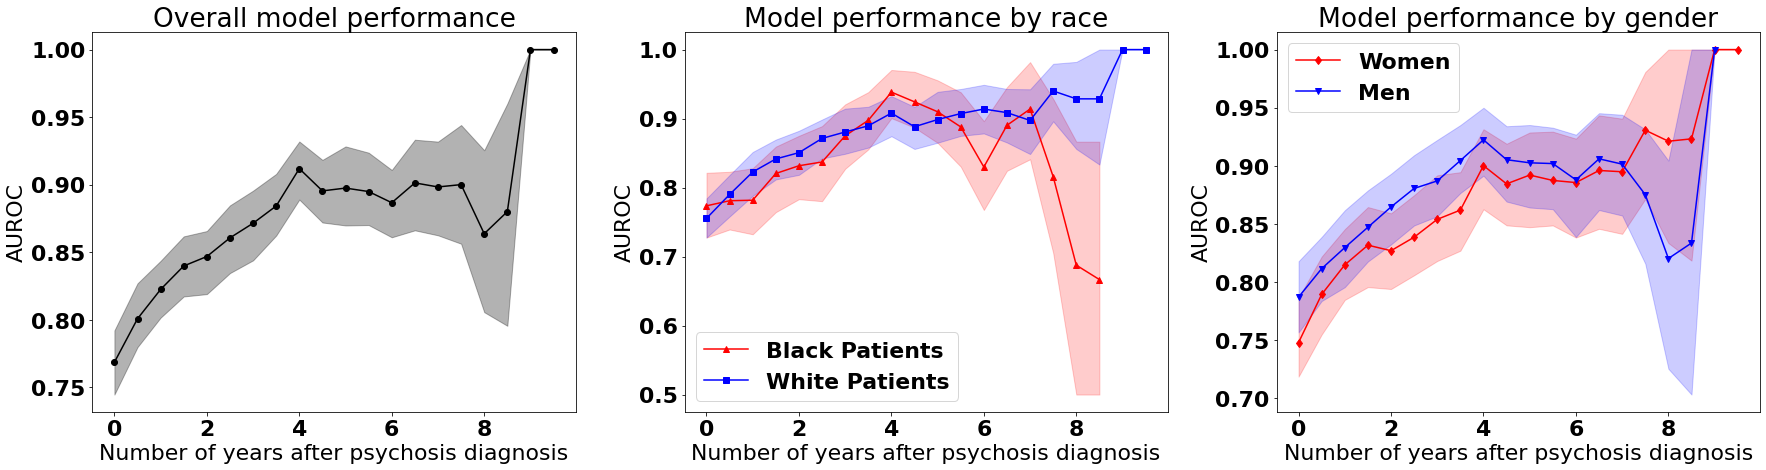

In [160]:
font = {'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.figure(figsize=(25, 7))

cutoff_ind = len(auroc_b)
## Forwards iterations, by time
n_years = iterations[0:cutoff_ind]

auroc = np.asarray(auroc[0:cutoff_ind])
auroc_ci = np.asarray(auroc_ci[0:cutoff_ind])

plt.subplot(1,3,1)
# all patients
plt.plot(n_years, auroc, color = 'black', label = 'AUROC', marker = 'o')
plt.fill_between(n_years, np.abs(auroc_ci.T)[0,:], np.abs(auroc_ci.T)[1,:], color='black', alpha=0.3)

plt.xlabel('Number of years after psychosis diagnosis')
plt.ylabel('AUROC')
plt.title('Overall model performance')


plt.subplot(1,3,2)
## Black Patients
auroc_b = np.asarray(auroc_b[0:cutoff_ind])
auroc_ci_b = np.asarray(auroc_ci_b[0:cutoff_ind])
plt.plot(n_years, auroc_b, label = 'Black Patients', color = 'red', marker = '^')
plt.fill_between(n_years, np.abs(auroc_ci_b.T)[0,:], np.abs(auroc_ci_b.T)[1,:], color='red', alpha=0.2)

## White Patients
auroc_w = np.asarray(auroc_w[0:cutoff_ind])
auroc_ci_w = np.asarray(auroc_ci_w[0:cutoff_ind])
plt.plot(n_years, auroc_w, label = 'White Patients', color = 'blue', marker = 's')
plt.fill_between(n_years, np.abs(auroc_ci_w.T)[0,:], np.abs(auroc_ci_w.T)[1,:], color='blue', alpha=0.2)

plt.xlabel('Number of years after psychosis diagnosis')
plt.ylabel('AUROC')
plt.title('Model performance by race')
plt.legend()

plt.subplot(1,3,3)
## Female Patients
auroc_f = np.asarray(auroc_f[0:cutoff_ind])
auroc_ci_f = np.asarray(auroc_ci_f[0:cutoff_ind])
plt.plot(n_years, auroc_f, label = 'Women', color = 'red', marker = 'd')
plt.fill_between(n_years, np.abs(auroc_ci_f.T)[0,:], np.abs(auroc_ci_f.T)[1,:], color='red', alpha=0.2)

## Male Patients
auroc_m = np.asarray(auroc_m[0:cutoff_ind])
auroc_ci_m = np.asarray(auroc_ci_m[0:cutoff_ind])
plt.plot(n_years, auroc_m, label = 'Men', color = 'blue', marker = 'v')
plt.fill_between(n_years, np.abs(auroc_ci_m.T)[0,:], np.abs(auroc_ci_m.T)[1,:], color='blue', alpha=0.2)

plt.xlabel('Number of years after psychosis diagnosis')
plt.ylabel('AUROC')
plt.title('Model performance by gender')
plt.legend()
plt.tight_layout()
plt.savefig('figures/xgboost_time_performance.pdf', dpi=300)
plt.show()

## Correlation between HCU (relative utilization) and model performance

In [ ]:
eps = 1e-10

patient_loss = -1*((test_labels['sz_flag']*np.log(test_labels['prob_1']))+(1-test_labels['sz_flag'])*(np.log(1-test_labels['prob_1']+eps)))
test_labels['bce_loss'] = patient_loss

In [91]:
patient_performance = test_labels.groupby('person_id').mean()['bce_loss']
df_hcu = pd.read_csv('stored_data/hcu_perpatient.csv')

patient_performance = pd.DataFrame(patient_performance).merge(df_hcu, how='left', left_index=True, right_on = 'person_id')

/tmp/ipykernel_474895/164393874.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [108]:
hcu_cols = ['Inpatient', 'Outpatient', 'ED', 'Psych_Inpatient', 'All']

patient_performance_subset = patient_performance#.loc[patient_performance['gender_concept_id']==8532]
for col in hcu_cols:
    corr = stats.pearsonr(patient_performance_subset['bce_loss'], patient_performance_subset[col])
    ci_low, ci_high = corr.confidence_interval()
    if corr.pvalue*5 < 0.01:
        print(col, corr.statistic, (ci_low, ci_high), corr.pvalue*5)

Inpatient 0.027843157240431574 (0.016577227700443783, 0.03910201796296144) 6.411210741909803e-06
Outpatient 0.018426816584823827 (0.007157171195251597, 0.029691781736802623) 0.006766136040328401
Psych_Inpatient 0.03812718765406608 (0.026867601774639968, 0.04937710037899715) 1.6534556762285758e-10
All 0.028501036818824804 (0.017235441643719884, 0.03975939642247239) 3.580397560849129e-06


## Stability Analysis: Figure 2, Figure 3
Look at stability analysis (performance on 1-alpha worst subgroups) for conditions/medications/labs/procedures and also the relative utilization scores from HCU

In [57]:
eps = 1e-10

patient_loss = -1*((test_labels['sz_flag']*np.log(test_labels['prob_1']))+(1-test_labels['sz_flag'])*(np.log(1-test_labels['prob_1']+eps)))
test_labels['bce_loss'] = patient_loss

In [65]:
cond_cols = save_cols[0:598]
med_cols = save_cols[598:751]
lab_cols = save_cols[751:1481]
visit_cols = save_cols[1481:1507]
procedure_cols = save_cols[1507:]

forward_visit_features = [i for i in visit_cols if 'recent' not in i]
inpatient_features = [i for i in forward_visit_features if 'inpatient' in i]
outpatient_features = [i for i in forward_visit_features if 'outpatient' in i]
ed_features = [i for i in forward_visit_features if 'ed' in i.lower()]
psych_inpatient_features = [i for i in forward_visit_features if 'nonhospitalization' in i]


In [66]:
black_patients = test_labels.loc[test_labels['race_concept_id']==8516]
white_patients = test_labels.loc[test_labels['race_concept_id']==8527]

female_patients = test_labels.loc[test_labels['gender_concept_id']==8532]
male_patients = test_labels.loc[test_labels['gender_concept_id']==8507]

In [109]:
df_index = ['Positive Visit Features', 'Inpatient', 'Outpatient', 'ED','Psychiatric Inpatient',
            'Conditions', 'Medications', 'Labs', 'Procedures', 'Visits']
list_alphas = 1-np.logspace(-2.5, 0, 30)
results_ci95 = pd.DataFrame(index=df_index, columns=(1-list_alphas))
results_mean = pd.DataFrame(index=df_index, columns=(1-list_alphas))

results_correlation = pd.DataFrame(index=df_index, columns=(1-list_alphas))
results_correlation_ci95 = pd.DataFrame(index=df_index, columns=(1-list_alphas))

df_test = pd.DataFrame(X_test, columns=save_cols)
df_test['sz_flag'] = test_labels['sz_flag']

for a_ind in tqdm(range(len(list_alphas))):
    alpha = list_alphas[a_ind]
    alpha_worst = test_labels['bce_loss'].sort_values(ascending=False).iloc[0:int(np.floor(len(test_labels)*(1-alpha)))]
    test_worst = df_test.loc[alpha_worst.index]
    for list_cols, name_list_cols in zip([cond_cols, med_cols, lab_cols, procedure_cols, visit_cols,
                                         forward_visit_features, inpatient_features, outpatient_features, ed_features, psych_inpatient_features], results_ci95.index):
        # getting overall feature values
        grouped_mean = test_worst[list_cols].mean(axis=1)
        ci_low, ci_high = stats.t.interval(0.95, len(test_worst)-1, loc=grouped_mean.mean(), scale=stats.sem(grouped_mean))
        ci95 = ci_high-grouped_mean.mean()
        
        results_mean.loc[name_list_cols, 1-alpha] = grouped_mean.mean()
        results_ci95.loc[name_list_cols, 1-alpha] = ci95
        
        # getting correlation between schizophrenia onset and feature values
        corr_val = test_worst['sz_flag'].corr(grouped_mean)
        corr_ci_low, corr_ci_high = stats.pearsonr(test_worst['sz_flag'], grouped_mean).confidence_interval(confidence_level=0.95)
        corr_ci95 = corr_ci_high-corr_val

        results_correlation.loc[name_list_cols, 1-alpha] = corr_val
        results_correlation_ci95.loc[name_list_cols, 1-alpha] = corr_ci95
        

100%|████████████████████████████████████████████████████| 30/30 [01:00<00:00,  2.01s/it]


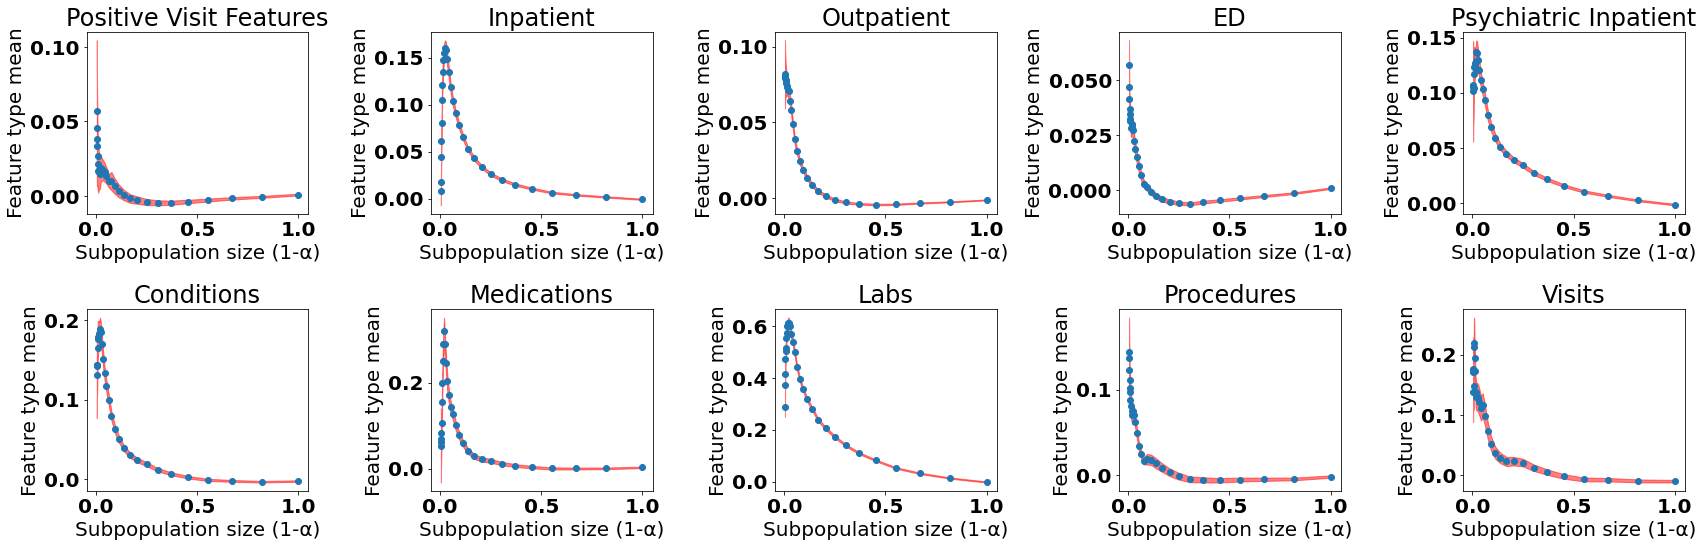

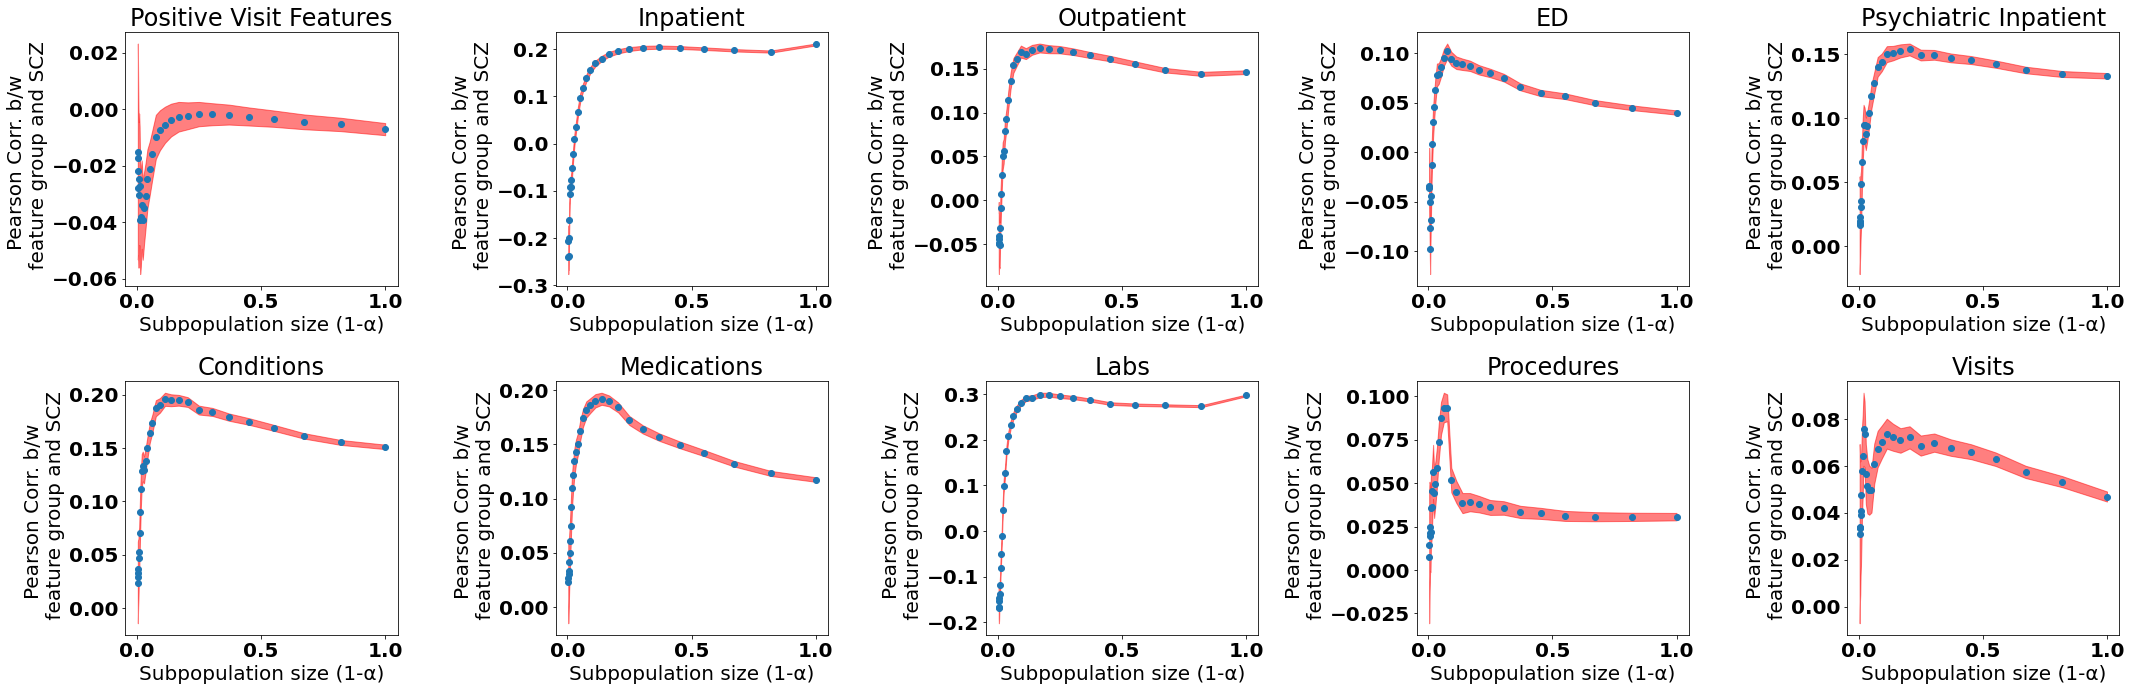

In [110]:
font = {'size':20,
       'weight':'bold'}
matplotlib.rc('font', **font)

plt.figure(figsize=(24,8))
for i in range(0, 10):
    plt.subplot(2,5,i+1)
    col = results_mean.index[i]
    plt.plot(1-list_alphas, results_mean.loc[col], 'o')
    ci_low = np.asarray(results_mean.loc[col]-results_ci95.loc[col]).astype(float)
    ci_high = np.asarray(results_mean.loc[col]+results_ci95.loc[col]).astype(float)
    plt.fill_between(1-list_alphas, ci_low, ci_high, color='red', alpha=0.5)
    
    plt.ylabel('Feature type mean')
    plt.xlabel('Subpopulation size (1-α)')
    plt.title(col)
    
plt.tight_layout()


plt.figure(figsize=(30,10))
for i in range(0, 10):
    plt.subplot(2,5,i+1)
    col = results_mean.index[i]
    plt.plot(1-list_alphas, results_correlation.loc[col], 'o')
    ci_low = np.asarray(results_correlation.loc[col]-results_correlation_ci95.loc[col]).astype(float)
    ci_high = np.asarray(results_correlation.loc[col]+results_correlation_ci95.loc[col]).astype(float)
    plt.fill_between(1-list_alphas, ci_low, ci_high, color='red', alpha = 0.5)
    
    plt.ylabel('Pearson Corr. b/w \n feature group and SCZ')
    plt.xlabel('Subpopulation size (1-α)')
    plt.title(col)
    
plt.tight_layout()
plt.savefig('figures/xgboost_stability_correlation.pdf', dpi=300)
plt.show()

## Sensitivity Analysis

In [156]:
mean_diffs = []
adj_pval = []
cis = []
for col in save_cols:
    tp = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['y_pred']==1)]
    tp = tp.merge(df_test[col], how='left', left_index=True, right_index=True)

    fn = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['y_pred']==0)]
    fn = fn.merge(df_test[col], how='left', left_index=True, right_index=True)
    
    mean_diffs.append(tp[col].mean()-fn[col].mean())
    adj_pval.append(stats.ttest_ind(tp[col], fn[col]).pvalue*len(save_cols))
    ci_low, ci_high = stats.ttest_ind(tp[col], fn[col]).confidence_interval()
    cis.append((ci_low, ci_high))
    
sensitivity_results = pd.DataFrame(index=save_cols, columns=['mean difference (TP-FN)', 'adj_pval'])
sensitivity_results['mean difference (TP-FN)'] = mean_diffs
sensitivity_results['adj_pval'] = adj_pval
sensitivity_results['CI'] = cis

sensitivity_results = sensitivity_results.loc[sensitivity_results['adj_pval']<0.01]
len(sensitivity_results)

/data/home/ak4885/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/data/home/ak4885/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/data/home/ak4885/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/data/home/ak4885/.local/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the

878

In [157]:
print('Medications:',len(set(med_cols).intersection(sensitivity_results.index))/len(med_cols))
print('Conditions:',len(set(cond_cols).intersection(sensitivity_results.index))/len(cond_cols))
print('Labs:',len(set(lab_cols).intersection(sensitivity_results.index))/len(lab_cols))
print('Procedures:',len(set(procedure_cols).intersection(sensitivity_results.index))/len(procedure_cols))
print('Visits:',len(set(visit_cols).intersection(sensitivity_results.index))/len(visit_cols))


sensitivity_results = sensitivity_results.loc[np.abs(sensitivity_results['mean difference (TP-FN)']) > 1]
sensitivity_results

Medications: 0.7777777777777778
Conditions: 0.5551839464882943
Labs: 0.4986301369863014
Procedures: 0.32413793103448274
Visits: 0.6153846153846154


,mean difference (TP-FN),adj_pval,CI
"CORTICOSTEROIDS, OTHER COMBINATIONS",1.081417,5.089272e-286,"(1.0237806725440828, 1.1390527686975525)"
ANTIHYPERTENSIVES AND DIURETICS IN COMBINATION,1.625743,0.000000e+00,"(1.5748088212037703, 1.6766778812589656)"
DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPHAGEAL REFLUX DISEASE (GORD),1.631809,0.000000e+00,"(1.5787634275190146, 1.6848554828261528)"
OTHER ANALGESICS AND ANTIPYRETICS,1.316063,0.000000e+00,"(1.2641616728730314, 1.3679641919442453)"
ANTISPASMODICS IN COMBINATION WITH PSYCHOLEPTICS,1.578731,0.000000e+00,"(1.5258698891400728, 1.631592513383966)"
PSYCHOLEPTICS AND PSYCHOANALEPTICS IN COMBINATION,1.616614,0.000000e+00,"(1.5605353532500095, 1.6726920979996214)"
ANTI-ACNE PREPARATIONS FOR TOPICAL USE,1.006295,7.685084e-118,"(0.9224015786515894, 1.09018806718026)"
ANTIDEPRESSANTS,1.560904,0.000000e+00,"(1.4956059084997835, 1.626202755318794)"
ANTIPSYCHOTICS,1.613636,0.000000e+00,"(1.559995742347743, 1.667275467691069)"
"ANTIADRENERGIC AGENTS, CENTRALLY ACTING",1.033389,1.573529e-272,"(0.9769400618972238, 1.089838462880803)"


In [137]:
# Mean difference (Black Pos-Neg) + pvals + CI # Mean Difference (White Pos-Neg) + pvals + CI

mean_diffs_black = []
adj_pval_black = []
cis_black = []

mean_diffs_white = []
adj_pval_white = []
cis_white = []

mean_diffs_female = []
adj_pval_female = []
cis_female = []

mean_diffs_male = []
adj_pval_male = []
cis_male = []


for col in sensitivity_results.index:
    black_pos = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['race_concept_id']==8516)]
    black_pos = black_pos.merge(df_test[col], how='left', left_index=True, right_index=True)
    
    white_pos = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['race_concept_id']==8527)]
    white_pos = white_pos.merge(df_test[col], how='left', left_index=True, right_index=True)

    female_pos = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['gender_concept_id']==8532)]
    female_pos = female_pos.merge(df_test[col], how='left', left_index=True, right_index=True)
    
    male_pos = test_labels.loc[(test_labels['sz_flag']==1)&(test_labels['gender_concept_id']==8507)]
    male_pos = male_pos.merge(df_test[col], how='left', left_index=True, right_index=True)
    
    all_neg = test_labels.loc[(test_labels['sz_flag']==0)]
    all_neg = all_neg.merge(df_test[col], how='left', left_index=True, right_index=True)
    
    mean_diffs_black.append(black_pos[col].mean()-all_neg[col].mean())
    adj_pval_black.append(stats.ttest_ind(black_pos[col], all_neg[col]).pvalue*len(save_cols))
    ci_low, ci_high = stats.ttest_ind(black_pos[col], all_neg[col]).confidence_interval()
    cis_black.append((ci_low, ci_high))
    
    mean_diffs_white.append(white_pos[col].mean()-all_neg[col].mean())
    adj_pval_white.append(stats.ttest_ind(white_pos[col], all_neg[col]).pvalue*len(save_cols))
    ci_low, ci_high = stats.ttest_ind(white_pos[col], all_neg[col]).confidence_interval()
    cis_white.append((ci_low, ci_high))

    
    mean_diffs_female.append(female_pos[col].mean()-all_neg[col].mean())
    adj_pval_female.append(stats.ttest_ind(female_pos[col], all_neg[col]).pvalue*len(save_cols))
    ci_low, ci_high = stats.ttest_ind(female_pos[col], all_neg[col]).confidence_interval()
    cis_female.append((ci_low, ci_high))

    
    mean_diffs_male.append(male_pos[col].mean()-all_neg[col].mean())
    adj_pval_male.append(stats.ttest_ind(male_pos[col], all_neg[col]).pvalue*len(save_cols))
    ci_low, ci_high = stats.ttest_ind(male_pos[col], all_neg[col]).confidence_interval()
    cis_male.append((ci_low, ci_high))

    
sensitivity_results['mean difference (TP-FN)_black'] = mean_diffs_black
sensitivity_results['adj_pval_black'] = adj_pval_black
sensitivity_results['CI_black'] = cis_black

sensitivity_results['mean difference (TP-FN)_white'] = mean_diffs_white
sensitivity_results['adj_pval_white'] = adj_pval_white
sensitivity_results['CI_white'] = cis_white

sensitivity_results['mean difference (TP-FN)_female'] = mean_diffs_female
sensitivity_results['adj_pval_female'] = adj_pval_female
sensitivity_results['CI_female'] = cis_female

sensitivity_results['mean difference (TP-FN)_male'] = mean_diffs_male
sensitivity_results['adj_pval_male'] = adj_pval_male
sensitivity_results['CI_male'] = cis_male



In [141]:
sensitivity_results.sort_values('mean difference (TP-FN)', ascending=False)

,mean difference (TP-FN),adj_pval,CI,mean difference (TP-FN)_black,adj_pval_black,CI_black,mean difference (TP-FN)_white,adj_pval_white,CI_white,mean difference (TP-FN)_female,adj_pval_female,CI_female,mean difference (TP-FN)_male,adj_pval_male,CI_male
DRUGS FOR PEPTIC ULCER AND GASTRO-OESOPHAGEAL REFLUX DISEASE (GORD),1.631809,0.000000e+00,"(1.5787634275190146, 1.6848554828261528)",1.466978,0.000000e+00,"(1.4467596609364914, 1.4871963496623821)",2.047248,0.0,"(2.0345585198606173, 2.059936634389657)",1.676724,0.000000,"(1.6619050201319978, 1.691543747191849)",1.934433,0.0,"(1.9209148888221232, 1.9479502756473503)"
ANTIHYPERTENSIVES AND DIURETICS IN COMBINATION,1.625743,0.000000e+00,"(1.5748088212037703, 1.6766778812589656)",1.416721,0.000000e+00,"(1.3960071998685204, 1.4374341435073479)",1.982722,0.0,"(1.9698644699417824, 1.9955798094480504)",1.471842,0.000000,"(1.4568773931185988, 1.4868074761617833)",2.021699,0.0,"(2.007827595998823, 2.035571379753082)"
PSYCHOLEPTICS AND PSYCHOANALEPTICS IN COMBINATION,1.616614,0.000000e+00,"(1.5605353532500095, 1.6726920979996214)",1.531194,0.000000e+00,"(1.5103872102547993, 1.5520001337741254)",2.010847,0.0,"(1.9978949047029437, 2.023799253905001)",1.603805,0.000000,"(1.5886512002705857, 1.6189592073525676)",2.046873,0.0,"(2.032959482704815, 2.0607872257486384)"
ANTIPSYCHOTICS,1.613636,0.000000e+00,"(1.559995742347743, 1.667275467691069)",1.317068,0.000000e+00,"(1.2981775788841423, 1.3359590275989004)",2.037515,0.0,"(2.025478724200462, 2.0495522710473084)",1.456541,0.000000,"(1.442709312884755, 1.4703730499453147)",2.094225,0.0,"(2.081354391889036, 2.107094769668885)"
ANTISPASMODICS IN COMBINATION WITH PSYCHOLEPTICS,1.578731,0.000000e+00,"(1.5258698891400728, 1.631592513383966)",1.471764,0.000000e+00,"(1.4517088974156394, 1.4918195166124695)",2.030586,0.0,"(2.0180322102743453, 2.0431393130454314)",1.552987,0.000000,"(1.5384005938789618, 1.567572416980099)",2.040870,0.0,"(2.027397734761806, 2.054341673747858)"
ANTIDEPRESSANTS,1.560904,0.000000e+00,"(1.4956059084997835, 1.626202755318794)",0.655103,0.000000e+00,"(0.632540252747998, 0.6776663872277409)",1.919877,0.0,"(1.9054563879336783, 1.9342971253875072)",1.627524,0.000000,"(1.6109028897192728, 1.6441454150415078)",1.332146,0.0,"(1.3168033948546858, 1.3474889950790956)"
num_visits_outpatient,1.400511,0.000000e+00,"(1.334971243310561, 1.4660503411019676)",1.090913,0.000000e+00,"(1.0695967493443492, 1.1122294198231273)",2.046204,0.0,"(2.0321242415863767, 2.0602829136511986)",1.622115,0.000000,"(1.60605058081093, 1.6381793039165122)",1.668110,0.0,"(1.6535370055626926, 1.6826838593968647)"
OTHER ANALGESICS AND ANTIPYRETICS,1.316063,0.000000e+00,"(1.2641616728730314, 1.3679641919442453)",1.334657,0.000000e+00,"(1.3141362540450254, 1.3551781734884365)",2.048374,0.0,"(2.035515959867184, 2.0612326291415464)",1.519929,0.000000,"(1.5050069626044051, 1.5348511338958752)",1.998887,0.0,"(1.9850992856793153, 2.012674781342026)"
"CORTICOSTEROIDS, OTHER COMBINATIONS",1.081417,5.089272e-286,"(1.0237806725440828, 1.1390527686975525)",0.475013,0.000000e+00,"(0.4510470083154336, 0.49897815272971585)",0.966593,0.0,"(0.951581796449391, 0.9816035074895938)",0.776233,0.000000,"(0.7589336826107453, 0.7935317734993588)",0.767655,0.0,"(0.7514935197115937, 0.7838161879248802)"
"ANTIADRENERGIC AGENTS, CENTRALLY ACTING",1.033389,1.573529e-272,"(0.9769400618972238, 1.089838462880803)",0.193112,3.920667e-58,"(0.17021135835883208, 0.21601244134490424)",0.992562,0.0,"(0.9779667945267279, 1.0071581985171307)",0.335883,0.000000,"(0.31924490305552844, 0.35252202479707784)",1.063846,0.0,"(1.0482217553286919, 1.079469527916808)"


## Odds Ratio

In [148]:
patient_grouped = test_labels.groupby('person_id').max()[['race_concept_id', 'gender_concept_id', 'y_pred', 'sz_flag']]
patient_grouped.groupby(['race_concept_id', 'sz_flag']).count()

gender_concept_id  y_pred
race_concept_id sz_flag                           
0               0                     4487    4487
                1                       97      97
8516            0                     7559    7559
                1                      136     136
8527            0                    17686   17686
                1                      274     274